<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/bia/lab9/bia_exercises9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# exercise 1

import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [5]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.rand((num_examples, len(w)))
    y = X @ w + b
    y += torch.normal(0, 0.1, y.shape)
    return X, y.reshape(-1, 1)

In [6]:
true_w = torch.tensor([0.15, -0.2, 0.1])
true_b = 0.2
features, labels = synthetic_data(true_w, true_b, 2000)

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [8]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [9]:
batch_size = 20
data_iter = load_array((features, labels), batch_size)

In [10]:
def mse_loss(model_outputs, correct_outputs):
    return ((model_outputs - correct_outputs) ** 2) \
    .mean()

loss = mse_loss

In [11]:
def sgd_zero_grad(parameters):
    for parameter in parameters:
        if parameter.grad is not None:
            parameter.grad.fill_(0)

In [12]:
def sgd_step(parameters, lr):
    with torch.no_grad():
        for parameter in parameters:
            parameter.sub_(lr*parameter.grad)

In [13]:
from torch import nn

net = nn.Sequential(nn.Linear(3, 1))
net[0].weight.data.fill_(3)
net[0].bias.data.fill_(3)

tensor([3.])

In [14]:
num_epochs = 40
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        sgd_zero_grad(net.parameters())
        l.backward()
        sgd_step(net.parameters(), 0.02)
    l = loss(net(features), labels)
    print(f'Epoch {epoch + 1}, Loss {l:f}')

Epoch 1, Loss 0.144151
Epoch 2, Loss 0.101097
Epoch 3, Loss 0.071826
Epoch 4, Loss 0.051985
Epoch 5, Loss 0.038503
Epoch 6, Loss 0.029337
Epoch 7, Loss 0.023039
Epoch 8, Loss 0.018781
Epoch 9, Loss 0.015920
Epoch 10, Loss 0.013921
Epoch 11, Loss 0.012571
Epoch 12, Loss 0.011648
Epoch 13, Loss 0.011101
Epoch 14, Loss 0.010594
Epoch 15, Loss 0.010308
Epoch 16, Loss 0.010107
Epoch 17, Loss 0.009975
Epoch 18, Loss 0.009890
Epoch 19, Loss 0.009841
Epoch 20, Loss 0.009795
Epoch 21, Loss 0.009760
Epoch 22, Loss 0.009752
Epoch 23, Loss 0.009720
Epoch 24, Loss 0.009730
Epoch 25, Loss 0.009724
Epoch 26, Loss 0.009696
Epoch 27, Loss 0.009694
Epoch 28, Loss 0.009692
Epoch 29, Loss 0.009705
Epoch 30, Loss 0.009690
Epoch 31, Loss 0.009723
Epoch 32, Loss 0.009700
Epoch 33, Loss 0.009690
Epoch 34, Loss 0.009740
Epoch 35, Loss 0.009726
Epoch 36, Loss 0.009689
Epoch 37, Loss 0.009690
Epoch 38, Loss 0.009692
Epoch 39, Loss 0.009687
Epoch 40, Loss 0.009699


In [15]:
print(net[0].weight.data)
print(true_w)
print(net[0].bias.data)
print(true_b)

tensor([[ 0.1407, -0.1917,  0.0906]])
tensor([ 0.1500, -0.2000,  0.1000])
tensor([0.2014])
0.2


In [17]:
# exercise 2

import torchvision
from torchvision import transforms

trans = transforms.Compose([
    transforms.Resize((300, 100)),
    transforms.ToTensor()
])
imag_dataset = torchvision.datasets.Imagenette(
    root="../data", transform=trans, download=True)

100%|██████████| 1.56G/1.56G [00:30<00:00, 51.9MB/s]


Extracting ../data/imagenette2.tgz to ../data


In [18]:
imag_dataset

Dataset Imagenette
    Number of datapoints: 9469
    Root location: ../data
    StandardTransform
Transform: Compose(
               Resize(size=(300, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [19]:
imag_train, imag_test = torch.utils.data.random_split(imag_dataset, [8912, 557],
                                                           generator=torch.Generator().manual_seed(42))

In [20]:
imag_train, imag_val = torch.utils.data.random_split(imag_train, [4456, 4456],
                                                           generator=torch.Generator().manual_seed(42))

In [42]:
net = nn.Sequential(nn.Flatten(), nn.Linear(90000, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0, 0.1)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=90000, out_features=10, bias=True)
)

In [43]:
batch_size = 100

train_iter = torch.utils.data.DataLoader(imag_train, batch_size, shuffle=True,
                            num_workers=2)
val_iter = torch.utils.data.DataLoader(imag_val, batch_size, shuffle=False,
                num_workers=2)
test_iter = torch.utils.data.DataLoader(imag_test, batch_size, shuffle=False,
                num_workers=2)

In [44]:
loss = nn.CrossEntropyLoss()

In [45]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [46]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [47]:
def train_epoch(net, train_iter, loss, optimizer):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [48]:
def train(net, train_iter, val_iter, loss, num_epochs, optimizer):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [49]:
num_epochs = 5
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 559.05, Train accuracy 13.35, Validation loss 389.48, Validation accuracy 19.84
Epoch 2, Train loss 410.16, Train accuracy 17.59, Validation loss 485.42, Validation accuracy 17.98
Epoch 3, Train loss 320.49, Train accuracy 20.74, Validation loss 360.11, Validation accuracy 17.15
Epoch 4, Train loss 360.94, Train accuracy 19.55, Validation loss 307.20, Validation accuracy 20.24
Epoch 5, Train loss 332.28, Train accuracy 20.83, Validation loss 572.03, Validation accuracy 15.93


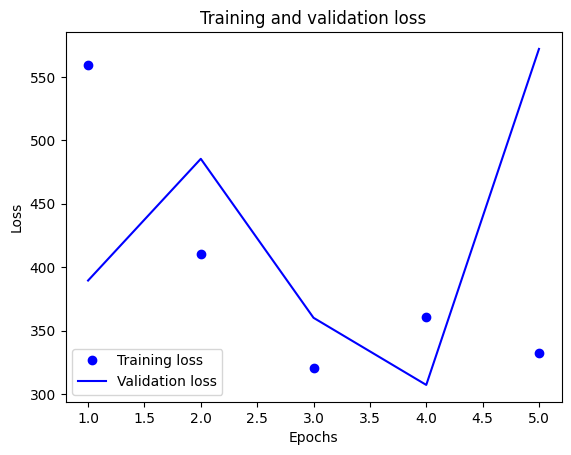

In [50]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_loss_all, val_loss_all)

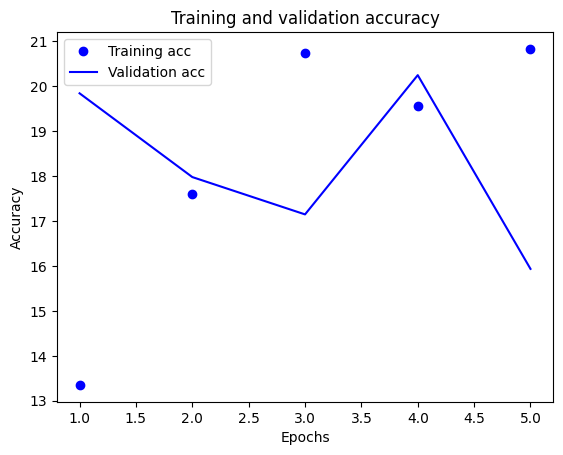

In [51]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(train_acc_all, val_acc_all)

In [52]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 547.96, Test accuracy 15.98


In [53]:
# exercise 3

imag_dataset = torchvision.datasets.Imagenette(
    root="../data", transform=trans)

imag_train, imag_test = torch.utils.data.random_split(imag_dataset, [9000, 469],
                                                           generator=torch.Generator().manual_seed(42))
imag_train, imag_val = torch.utils.data.random_split(imag_train, [4000, 5000],
                                                           generator=torch.Generator().manual_seed(42))

batch_size = 150
train_iter = torch.utils.data.DataLoader(imag_train, batch_size, shuffle=True,
                            num_workers=2)
val_iter = torch.utils.data.DataLoader(imag_val, batch_size, shuffle=False,
                num_workers=2)
test_iter = torch.utils.data.DataLoader(imag_test, batch_size, shuffle=False,
                num_workers=2)


In [55]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(90000, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(0.35),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)


def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0, 0.1)
        m.bias.data.fill_(0)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=90000, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=128, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.35, inplace=False)
  (8): Linear(in_features=128, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=10, bias=True)
)

In [56]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.15)

In [57]:
num_epochs = 15
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss nan, Train accuracy 9.45, Validation loss nan, Validation accuracy 10.30
Epoch 2, Train loss nan, Train accuracy 9.85, Validation loss nan, Validation accuracy 10.30
Epoch 3, Train loss nan, Train accuracy 9.85, Validation loss nan, Validation accuracy 10.30
Epoch 4, Train loss nan, Train accuracy 9.85, Validation loss nan, Validation accuracy 10.30
Epoch 5, Train loss nan, Train accuracy 9.85, Validation loss nan, Validation accuracy 10.30


KeyboardInterrupt: 

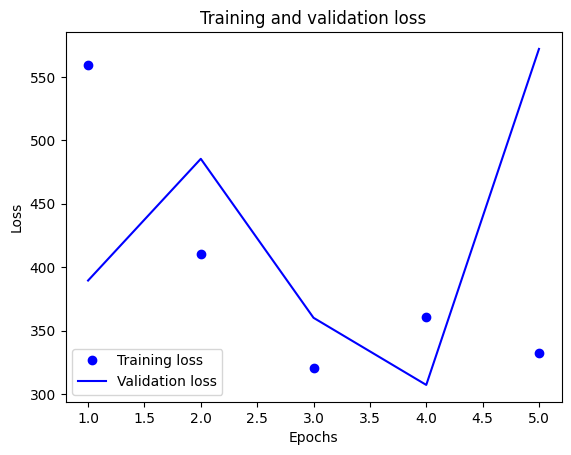

In [58]:
plot_loss(train_loss_all, val_loss_all)

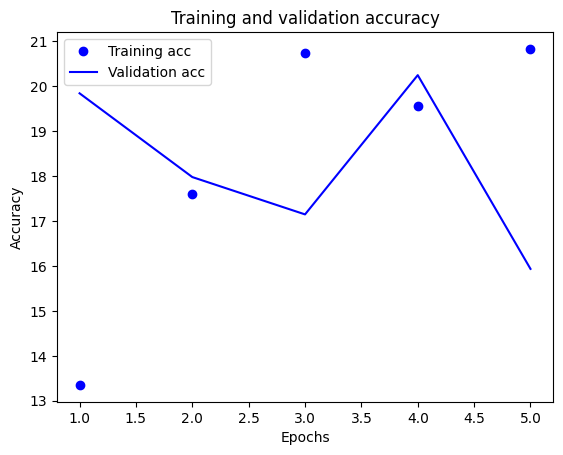

In [59]:
plot_accuracy(train_acc_all, val_acc_all)

In [60]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss nan, Test accuracy 11.51
